In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mirt import MIRT, JointMIRT

df = pd.read_csv('data.csv', low_memory=False)
riasec_df = df.iloc[:, :48]
tipi_df = df.iloc[:, 51:61]
vcl_df = df.iloc[:, 61:77]

n_students = riasec_df.shape[0]
n_riasec_items = riasec_df.shape[1]
n_tipi_items = tipi_df.shape[1]
n_vcl_items = vcl_df.shape[1]

n_riasec_categories = 5
n_tipi_categories = 7


riasec_df.replace(0,1,inplace=True)
tipi_df.replace(0,1,inplace=True)


combined_responses = [riasec_df.values-1, tipi_df.values-1, vcl_df.values]

In [11]:
mirt = MIRT(n_students, n_riasec_items, n_dims=2, n_categories=n_riasec_categories)
mirt.specify_model(model_type="GPCM")
mirt.fit(riasec_df.values-1, n_epochs=500, lr=0.01)

single_theta = mirt.theta.detach().numpy()
single_a = mirt.item_model.a.detach().numpy()
single_b = mirt.item_model.b.detach().numpy()

Training MIRT Model:   0%|          | 0/500 [00:00<?, ?it/s]

In [15]:
single_theta_norm

array([[-0.5276467 ,  0.8034531 ],
       [-0.17926054, -0.5933209 ],
       [-0.5750046 , -0.1642677 ],
       ...,
       [-0.6288446 , -0.37810132],
       [-1.035421  ,  1.7729079 ],
       [ 0.61238945,  0.20101461]], shape=(145828, 2), dtype=float32)

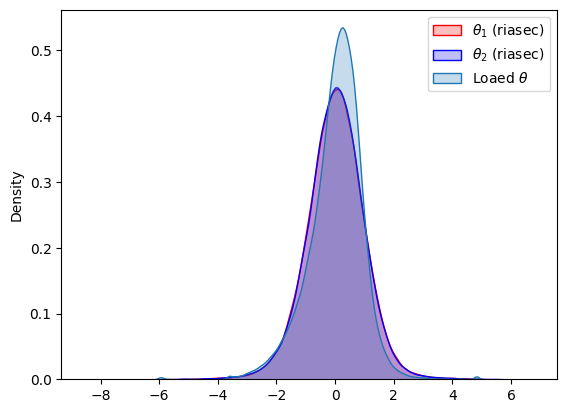

In [13]:
theta_df = pd.read_csv('thetas.csv')
theta_from_df = theta_df.values
fig, ax = plt.subplots()

single_theta = single_theta.squeeze()
mu = single_theta.mean(axis=0)
sigma = single_theta.std(axis=0)

single_theta_norm = (single_theta - mu) / sigma

# single_theta -= single_theta.mean()
# single_theta /= single_theta.std()

sns.kdeplot(single_theta_norm[:, 0], ax=ax ,label=r'$\theta_1$ (riasec)', color='red', fill=True)
sns.kdeplot(single_theta_norm[:, 1], ax=ax ,label=r'$\theta_2$ (riasec)', color='blue', fill=True)
sns.kdeplot(theta_from_df, ax=ax, label=r'Loaed $\theta$', color='green', fill=True)
plt.legend()
plt.show()

In [10]:
jmirt = JointMIRT(n_students, n_dims=2)
jmirt.add_model("GPCM", n_items=n_riasec_items, n_categories=n_riasec_categories)
jmirt.add_model("GPCM", n_items=n_tipi_items, n_categories=n_tipi_categories)
jmirt.add_model("2PL", n_items=n_vcl_items)

jmirt.fit(combined_responses, n_epochs=500, lr=0.01)

JointMIRT(
  (item_models): ModuleList(
    (0-1): 2 x GPCMModel()
    (2): TwoPLModel()
  )
)

In [16]:
riasec_a = jmirt.item_models[0].a.detach().numpy()
riasec_b = jmirt.item_models[0].b.detach().numpy()
tipi_a = jmirt.item_models[1].a.detach().numpy()
tipi_b = jmirt.item_models[1].b.detach().numpy()
vcl_a = jmirt.item_models[2].a.detach().numpy()
vcl_b = jmirt.item_models[2].b.detach().numpy()

In [19]:
riasec_prarms = pd.DataFrame(np.concatenate([riasec_a, riasec_b], axis=1), columns=['a1', 'a2', 'b1', 'b2', 'b3', 'b4'])
tipi_prarms = pd.DataFrame(np.concatenate([tipi_a, tipi_b], axis=1), columns=['a1', 'a2','b1', 'b2', 'b3', 'b4', 'b5', 'b6'])
vcl_prarms = pd.DataFrame(np.column_stack([vcl_a, vcl_b]), columns=['a1', 'a2', 'b'])

vcl_prarms.to_csv('vcl_params_2d.csv', index=False)
tipi_prarms.to_csv('tipi_params_2d.csv', index=False)
riasec_prarms.to_csv('riasec_params_2d.csv', index=False)

In [27]:
np.dot(riasec_a, mu)

array([-0.00599717, -0.00627748, -0.00555454, -0.00624913, -0.00746144,
       -0.00724379, -0.00852262, -0.00735261, -0.00300398, -0.00364933,
       -0.00392329, -0.00409673, -0.00397275, -0.00432108, -0.00404351,
       -0.00520405, -0.00455091, -0.00472298, -0.00382707, -0.00372882,
       -0.00318771, -0.0041369 , -0.00425502, -0.00548453, -0.00451201,
       -0.00415842, -0.00362986, -0.00540313, -0.00385847, -0.00501304,
       -0.00511103, -0.00520751, -0.00617618, -0.00616472, -0.00795602,
       -0.00540206, -0.00660838, -0.00685951, -0.00547804, -0.00855963,
       -0.00670478, -0.007948  , -0.0081398 , -0.00783817, -0.00599425,
       -0.00718403, -0.00779551, -0.00926719], dtype=float32)

In [33]:
np.mean(5)

np.float64(5.0)

In [35]:
joint_theta = jmirt.theta.detach().numpy().squeeze()
mu = joint_theta.mean(axis=0)
sigma = joint_theta.std(axis=0)
joint_theta_norm = (joint_theta - mu) / sigma


pd.DataFrame(single_theta_norm, columns=['theta1', 'theta2']).to_csv('single_theta_2d.csv', index=False)
pd.DataFrame(joint_theta, columns=['theta1', 'theta2']).to_csv('joint_theta_2d.csv', index=False)
pd.DataFrame(joint_theta_norm, columns=['theta1', 'theta2']).to_csv('joint_theta_norm_2d.csv', index=False)

def a_norm(a, sigma):
    return a * sigma
def gpcm_b_norm(b, a, mu, sigma):
    a_eff = np.mean(a, axis=1)
    mu_eff = np.mean(mu)
    sigma_eff = np.mean(sigma)
    
    T = np.cumsum(b, axis=1)
    T = np.concatenate([np.zeros((T.shape[0], 1)), T], axis=1)
    T_norm = np.zeros_like(T)
    for c in range(T.shape[1]):
        T_norm[:, c] = (T[:, c] - c * a_eff * mu_eff) / sigma_eff
    return np.diff(T_norm, axis=1)

riasec_a_norm = a_norm(riasec_a, sigma)
riasec_b_norm = gpcm_b_norm(riasec_b, riasec_a, mu, sigma)
tipi_a_norm = a_norm(tipi_a, sigma)
tipi_b_norm = gpcm_b_norm(tipi_b, tipi_a, mu, sigma)
vcl_a_norm = a_norm(vcl_a, sigma)
vcl_b_norm = (vcl_b - mu.mean()) / sigma.mean()

In [36]:
riasec_norm_params = pd.DataFrame(np.concatenate([riasec_a_norm, riasec_b_norm], axis=1), columns=['a1', 'a2', 'b1', 'b2', 'b3', 'b4'])
tipi_norm_params = pd.DataFrame(np.concatenate([tipi_a_norm, tipi_b_norm], axis=1), columns=['a1', 'a2', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6'])
vcl_norm_params = pd.DataFrame(np.column_stack([vcl_a_norm, vcl_b_norm]), columns=['a1', 'a2', 'b'])

vcl_norm_params.to_csv('vcl_norm_params_2d.csv', index=False)
tipi_norm_params.to_csv('tipi_norm_params_2d.csv', index=False)
riasec_norm_params.to_csv('riasec_norm_params_2d.csv', index=False)

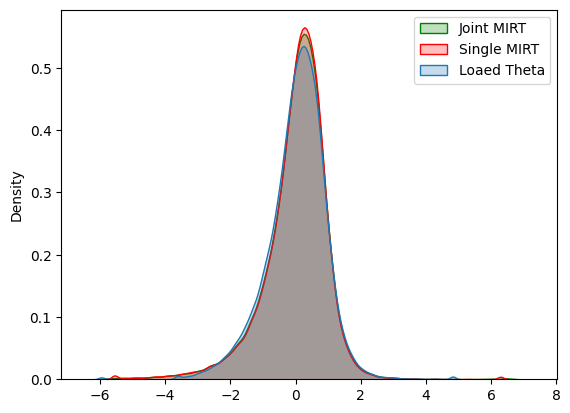

In [30]:
fig, ax = plt.subplots()
sns.kdeplot(joint_theta_norm, ax=ax, label='Joint MIRT', color='green', fill=True)
sns.kdeplot(single_theta, ax=ax ,label='Single MIRT', color='red', fill=True)
sns.kdeplot(theta_from_df, ax=ax, label='Loaed Theta', color='blue', fill=True)
plt.legend()
plt.show()


In [47]:
a

array([0.60046395, 0.58386112, 0.57463879, 0.65672251, 0.92233382,
       0.68541399, 1.05658339, 0.75260801, 0.19993795, 0.22499376,
       0.2456604 , 0.27577349, 0.26164252, 0.26543406, 0.2766576 ,
       0.3621235 , 0.26832822, 0.26573055, 0.23353414, 0.2101195 ,
       0.18027413, 0.24646335, 0.29103151, 0.32201758, 0.29627682,
       0.25760717, 0.21803928, 0.3645051 , 0.22638123, 0.31140905,
       0.30487465, 0.34002491, 0.56502873, 0.55086092, 0.7144222 ,
       0.38863218, 0.61991643, 0.57198217, 0.48122447, 0.66009206,
       0.81254594, 0.96486336, 1.06960654, 0.9122826 , 0.68206916,
       0.77694471, 0.98779116, 1.29337457])

In [68]:
np.concatenate([riasec_a, single_a, a[..., np.newaxis]], axis=1).shape

(48, 3)

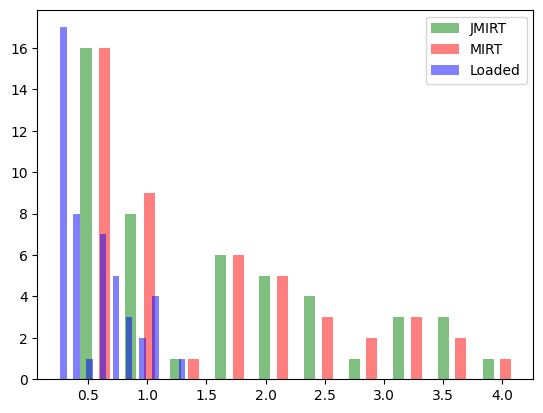

In [78]:
item_pars = pd.read_csv('item_pars.csv').values

a = item_pars[:, 0]
b = item_pars[:, 1:5]

combined_a = np.concatenate([riasec_a, single_a, a[..., np.newaxis]], axis=1)
label = ['JMIRT', 'MIRT', 'Loaded']
plt.hist(riasec_a.squeeze(), bins=10, alpha=0.5, label='JMIRT', color='green', align='left', rwidth=0.25)
plt.hist(single_a.squeeze(), bins=10, alpha=0.5, label='MIRT', color='red', align='mid', rwidth=0.25)
plt.hist(a, bins=10, alpha=0.5, label='Loaded', color='blue', align='right', rwidth=0.5)
plt.legend()
plt.show()